In [ ]:
!pip install geomloss[full]

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import time

import torch
from geomloss import SamplesLoss

use_cuda = torch.cuda.is_available()
dtype    = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
print(use_cuda)

True


In [36]:
import torch
from random import choices
import imageio
from skimage.transform import resize

def load_image(fname) :
    img = imageio.imread(fname)  # RGB
    print(img.shape)
    img = resize(img,(600,600))
    return img #/ 255.         # Normalized to [0,1]

def RGB_cloud(fname, sampling, dtype=torch.FloatTensor) :
    A = load_image(fname)
    A = A[::sampling, ::sampling, :]
    return torch.from_numpy(A).type(dtype).view(-1,3)

def display_cloud(ax, x) :
    x_ = x.detach().cpu().numpy()
    ax.scatter( x_[:,0], x_[:,1], x_[:,2],
                s = 25*500 / len(x_), c = x_ )

def display_image(ax, x) :
    W = int(np.sqrt(len(x)))
    x_ = x.view(W,W,3).detach().cpu().numpy()
    ax.imshow( x_ )

(464, 599, 3)
(600, 750, 3)


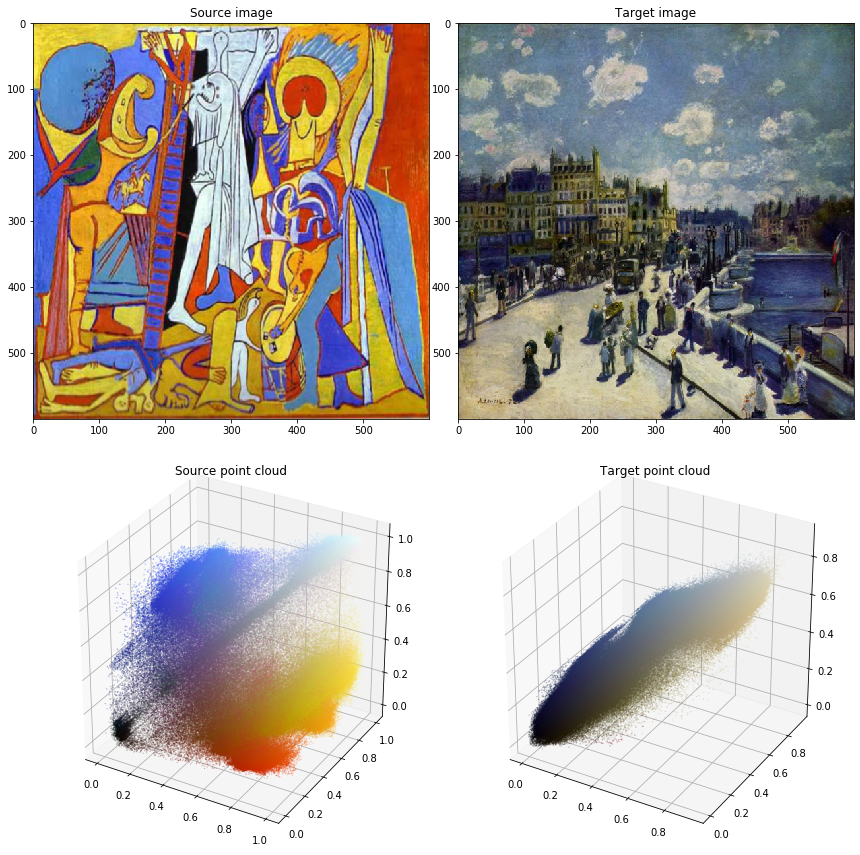

In [37]:
sampling = 8 if not use_cuda else 1

X_i = RGB_cloud("../im/Picasso.jpg",    sampling, dtype)
Y_j = RGB_cloud("../im/renoirPont.jpeg", sampling, dtype)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(2,2,1) ; display_image(ax, X_i) ; ax.set_title("Source image")
ax = fig.add_subplot(2,2,2) ; display_image(ax, Y_j) ; ax.set_title("Target image")

ax = fig.add_subplot(2, 2, 3, projection='3d') ; display_cloud(ax, X_i) ; ax.set_title("Source point cloud")
ax = fig.add_subplot(2, 2, 4, projection='3d') ; display_cloud(ax, Y_j) ; ax.set_title("Target point cloud")
plt.tight_layout()

In [38]:
def color_transfer(loss, lr=1) :
    """Flows along the gradient of the loss function.

    Parameters:
        loss ((x_i,y_j) -> torch float number):
            Real-valued loss function.
        lr (float, default = 1):
            Learning rate, i.e. time step.
    """

    # Parameters for the gradient descent
    Nsteps = 11
    display_its = [1, 10]

    # Make sure that we won't modify the reference samples
    x_i, y_j = X_i.clone(), Y_j.clone()

    # We're going to perform gradient descent on Loss(α, β)
    # wrt. the positions x_i of the diracs masses that make up α:
    x_i.requires_grad = True

    t_0 = time.time()


    plt.figure(figsize=(12,12)) ; k = 3
    ax = plt.subplot(2,2,1) ; display_image(ax, X_i) ; ax.set_title("Source image")
    plt.xticks([], []); plt.yticks([], [])
    ax = plt.subplot(2,2,2) ; display_image(ax, Y_j) ; ax.set_title("Target image")
    plt.xticks([], []); plt.yticks([], [])

    for i in range(Nsteps): # Euler scheme ===============
        # Compute cost and gradient
        L_αβ = loss(x_i, y_j)
        [g]  = torch.autograd.grad(L_αβ, [x_i])

        if i in display_its : # display
            ax = plt.subplot(2,2,k) ; display_image(ax, x_i) ; ax.set_title("it = {}".format(i))
            k = k+1 ; plt.xticks([], []); plt.yticks([], [])

        # in-place modification of the tensor's values
        x_i.data -= lr * len(x_i) * g

    plt.title("it = {}, elapsed time: {:.2f}s/it".format(i, (time.time() - t_0)/Nsteps ))
    plt.tight_layout()

In [1]:
#color_transfer(SamplesLoss("sinkhorn", blur=.3))